In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras
import tensorflow as tf
from PIL import Image
import os
import keras.backend as K
import math

In [2]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [3]:
model = keras.models.load_model('best_model.h5')

In [4]:
gb_model = keras.models.Model(inputs = [model.inputs],
                             outputs = [model.get_layer("conv2d_4").output])

In [5]:
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [6]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [7]:
classes = ['Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Reptilia']

In [88]:
test_imgs = []
pref = '../inaturalist_12K/'
test_path = pref+'test/'
labels = np.zeros((30,10))
cnt = 0
for i in range(10):
    lst = os.listdir(test_path+classes[i])
    idxs = np.random.choice(len(lst),3)
    for j in idxs:
        img = Image.open(test_path+classes[i]+'/'+lst[j])
        img = img.resize((224,224))
        test_imgs.append(np.asarray(img)*1./255)
        labels[cnt,i] = 1
        cnt+=1
fin_shape = model.get_layer("conv2d_4").output.shape[1:]

img_no = np.random.choice(30)
tstimg = test_imgs[img_no]

In [89]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [90]:
ans_imgs = []
for i in range(10):
    neuron = [np.random.randint(0,k-1) for k in fin_shape]
    mask = np.zeros(fin_shape)
    mask[neuron[0],neuron[1],neuron[2]] = 1
    with tf.GradientTape() as tape:
        inputs = tf.cast([tstimg], tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs) * mask
    
    grads = tape.gradient(outputs,inputs)[0] 
    ans_imgs.append((neuron,grads))

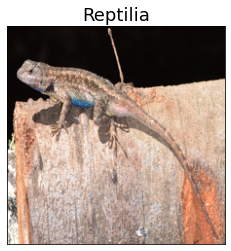

In [94]:
plt.imshow(tstimg)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False,labelleft=False,labeltop=False)
plt.title(classes[math.floor(img_no/3)],fontsize=18)

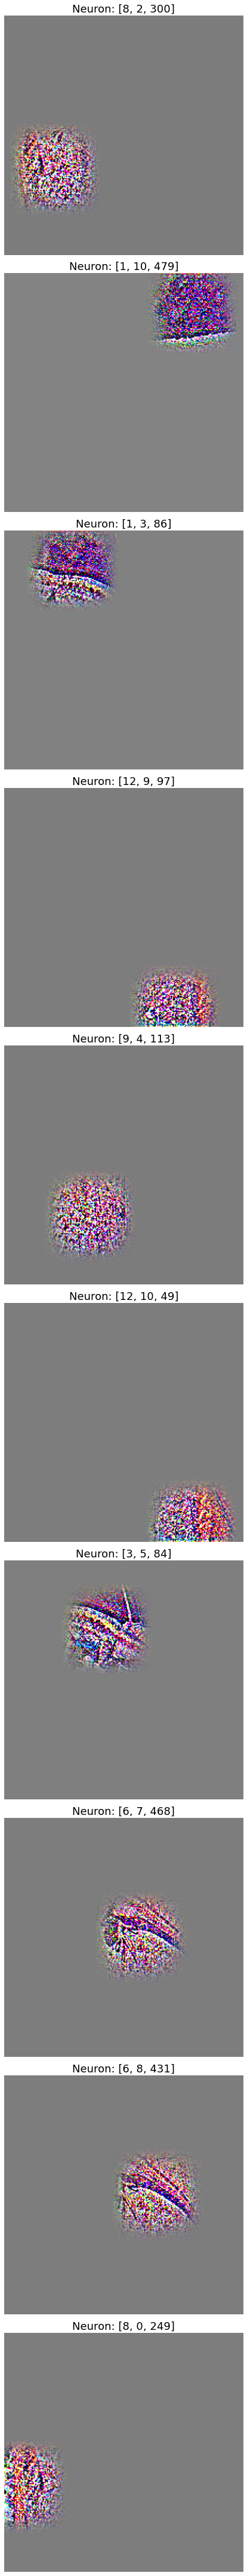

In [97]:
fig,ax = plt.subplots(10,1,figsize=(30,60))

for i,(neuron,image) in enumerate(ans_imgs):
    ax[i].imshow(deprocess_image(np.array(image)))
    ax[i].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False,labelleft=False,labeltop=False)
    ax[i].axis("off")
    ax[i].set_title("Neuron: {}".format(neuron),fontsize=18)
    
plt.tight_layout()
plt.savefig('q1-5.png',bbox_inches='tight')